In [1]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt

curr_directory = os.getcwd()

# Player Roster Information (Copied over from player_roster.ipynb)
teams = ['BOS','BRK','NYK','PHI','TOR','CHI','CLE','DET','IND','MIL','ATL','CHO','MIA','ORL','WAS',
         'DEN','MIN','OKC','POR','UTA','GSW','LAC','LAL','PHO','SAC','DAL','HOU','MEM','NOP','SAS']
        
# Dictionary of roster
# Ex. The roster of Boston Celtics players for the 2019-2020 season can be accessed using roster['BOS']['2019']
# It does not include any players/rookies for which there is no season data
roster = {}
    
for team in teams: 
    roster[team] = {}

# Initialize set for list of all players (with no repeats)
all_players = set()
    
for filename in os.listdir(os.path.join(curr_directory, 'data_sets/player_roster')):
    data = pd.read_csv(os.path.join('data_sets/player_roster', filename))
    year = filename[0:4]
    
    for team in teams:
        roster[team][year] = []
        
        players = data.loc[data['Tm'] == team]
        for ind in players.index: 
            player_name = players['Player'][ind].split('\\', 1)[0]
            if player_name not in roster[team][year]: 
                roster[team][year].append(player_name)
            
        all_players.update(roster[team][year])

num_players = len(all_players)
        
# Player dictionary that maps all players to index
player_index = dict(zip(list(all_players), range(len(all_players))))

In [2]:
game_data = pd.read_csv(os.path.join(curr_directory,'data_sets/nba.games.stats.csv'))

# Sort all values by the Date
game_data = game_data.sort_values(by=['Date'])

In [3]:
game_results = np.array(list(game_data['TeamPoints'] - game_data['OpponentPoints']))
teams = np.array(list(zip(game_data.Team, game_data.Opponent)))
dates = np.array(list(game_data['Date']))

In [4]:
unique_dates = list(set(dates))

repeat_indexes = []

for date in unique_dates: 
    same_day = np.where(dates == date)
    # suppose same_day = [0, 1, 2, 3, 4, 5]
    for i in same_day[0]: 
        # start with i = 0
        for j in same_day[0]: 
            # j = 0, 1, 2, 3, 4, 5
            if j > i: 
                if np.array_equal(np.flip(teams[j], axis=0) , teams[i]): 
                    repeat_indexes.append(j)

# Make new unique game results, teams and dates arrays
unique_game_results = game_results[repeat_indexes]
unique_teams = teams[repeat_indexes]
unique_dates = dates[repeat_indexes]

In [67]:
# Create a class for linear regression
class LinearRegression:
    def __init__(self, step_size=1e-4, max_iter=10000, eps=1e-4, theta=None, 
                  verbose=True):
        
        self.theta = theta
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps

    def sigmoid(self, z): 
        return 1.0 / (1 + np.exp(-z))
        
    def predict(self, x):
        z = np.dot(x.T, self.theta)
        return self.sigmoid(z)
    
    def gradBatchLossFunction(self, x_teams, y_teams):
        update = 0
        for i in range(x_teams.shape[0]):
            x = x_teams[i,:]
            x_new = np.reshape(x, (2*num_players + 1, 1))
            y = np.asscalar(y_teams[i])
            update += (self.predict(x_new) - y)*x_new
            
        return update
    
    def gradminiBatchLossFunction(self, x_teams, y_teams, batch_size):
        update = 0
        data = np.array(list(zip(x_teams, y_teams)))
        data_shuffle = data
        np.random.shuffle(data_shuffle)
        
        for i in range(batch_size):
            x = data[i, :]
            y = data[:, i]
            update += (y - predict(x))*x
            
        return update
    
    def fit(self, x, y, mini = False):
        iterations = 0
        abs_error = 1
        error_list = []
        batch_size = 32
        
        
        if self.theta is None: 
            self.theta = np.zeros((2*num_players + 1, 1))
        
        if mini == False:
            while iterations < self.max_iter and abs_error >= self.eps:
                error = self.step_size*self.gradBatchLossFunction(x, y)
                abs_error = np.linalg.norm(error, 2)
                error_list.append(abs_error)

                theta_new = self.theta - error
                self.theta = theta_new

                iterations += 1

                print('Error: {}'.format(abs_error))
        else:
            while iterations < self.max_iter and abs_error >= self.eps:
                error = self.step_size*self.gradminiBatchLossFunction(x, y, batch_size)
                abs_error = np.linalg.norm(error, 2)
                error_list.append(abs_error)

                theta_new = self.theta - error
                self.theta = theta_new

                iterations += 1
                

                print('Error: {}'.format(abs_error))
        
        print('Convergence!')
        plt.plot(error_list)
        plt.xlabel('Iterations')
        plt.ylabel('Error')
        plt.show()
        
    def process_data(self, teams, dates, results): 
        num_games = teams.shape[0]

        # Create x for all games
        # To access x for 0th game -- x[:, 0] 
        x_without_intercept = np.zeros((num_games, 2*num_players))
        
        for i in range(num_games): 
            z, t = self.x_for_game(teams[i], dates[i])
            combined = np.vstack((z, t))
            x_without_intercept[i, :] = combined[:,0]
            
        x = self.add_intercept(x_without_intercept)
        
        # Create y for all games (if team A wins, y = 1; if team B wins, y = 0)
        y = np.zeros((num_games, 1))
        for i in range(num_games): 
            if results[i] > 0: 
                y[i] = 1
            else:
                y[i] = 0
                
        return x, y
    
    def add_intercept(self, x): 
        new_x = np.zeros((x.shape[0], x.shape[1]+1))
        new_x[:, 0] = 1
        new_x[:, 1:] = x
        
        return new_x
        
    def x_for_game(self, teams, date): 
        x_1 = np.zeros((num_players, 1))
        x_2 = np.zeros((num_players, 1))

        if int(date[5:7]) < 9: 
            year = str(int(date[0:4]) - 1)
        else: 
            year = date[0:4]

        team_1_players = roster[teams[0]][year]
        for item in team_1_players: 
            x_1[player_index[item]] = 1

        team_2_players = roster[teams[1]][year]
        for item in team_2_players: 
            x_2[player_index[item]] = 1

        return x_1, x_2
    
    def symmetrize(self, m):
        for i in range(m.shape[0]):
            for j in range(i,m.shape[1]):
                m[i][j] = m[j][i] = 0.5*(m[j][i] + m[i][j])
                
        return m
    
    def antisymmetrize(self, m):
        for i in range(m.shape[0]):
            for j in range(i,m.shape[1]):
                m[i][j] = 0.5*(m[i][j] - m[j][i])
                m[j][i] = 0.5*(m[j][i] - m[i][j])
        return m
    
    def project(self, m):
        side = m.shape[0]
        S = self.symmetrize(m[0:int(side/2-1)][0:int(side/2-1)])
        S_minus = self.symmetrize(m[int(side/2):-1][int(side/2):-1])
        A = self.antisymmetrize(m[0:int(side/2-1)][int(side/2):-1])
        A_minus = self.antisymmetrize(m[int(side/2):-1][0:int(side/2-1)])
        S_new = (S - S_minus)/2
        S_minus_new = (S_minus - S)/2
        
        if np.linalg.norm(A.T-A_minus) < np.linalg.norm(A-A_minus):
            A_new = 0.5*(A+A_minus)
            A_minus_new = A_new.T
        else:
            A_new = 0.5*(A+A_minus.T)
            A_minus_new = A_new.T
            
        M = np.zeros(m.shape)
        M[0:int(side/2-1)][0:int(side/2-1)] = S
        M[int(side/2):-1][int(side/2):-1] = S_minus
        M[0:int(side/2-1)][int(side/2):-1] = A
        M[int(side/2):-1][0:int(side/2-1)] = A_minus
        
        return M

In [48]:
test = LinearRegression()
x, y = test.process_data(unique_teams[0:1229], unique_dates[0:1229], unique_game_results[0:1229])

Error: 0.016842357317192864
Error: 0.01667610119161008
Error: 0.01651208112665628
Error: 0.016350279748898005
Error: 0.016190679177222115
Error: 0.01603326100573074
Error: 0.01587800629671054
Error: 0.01572489558218862
Error: 0.015573908872740279
Error: 0.015425025672356058
Error: 0.015278224998305613
Error: 0.01513348540505612
Error: 0.014990785011412537
Error: 0.014850101530147241
Error: 0.014711412299477675
Error: 0.01457469431583323
Error: 0.014439924267427295
Error: 0.014307078568217675
Error: 0.014176133391899236
Error: 0.014047064705626385
Error: 0.013919848303211782
Error: 0.013794459837590249
Error: 0.01367087485237519
Error: 0.01354906881236823
Error: 0.013429017132912531
Error: 0.01331069520800593
Error: 0.01319407843711274
Error: 0.013079142250632472
Error: 0.012965862134000675
Error: 0.012854213650411481
Error: 0.012744172462163769
Error: 0.012635714350643156
Error: 0.012528815234960777
Error: 0.012423451189276876
Error: 0.012319598458843159
Error: 0.012217233474802438
Err

Error: 0.0039365935279916265
Error: 0.003927264043240892
Error: 0.003917985019260328
Error: 0.003908756019447421
Error: 0.003899576612176884
Error: 0.0038904463707323126
Error: 0.003881364873238932
Error: 0.0038723317025974088
Error: 0.0038633464464187094
Error: 0.003854408696959987
Error: 0.003845518051061476
Error: 0.003836674110084392
Error: 0.00382787647984978
Error: 0.003819124770578347
Error: 0.003810418596831215
Error: 0.003801757577451612
Error: 0.003793141335507457
Error: 0.0037845694982348503
Error: 0.0037760416969824227
Error: 0.0037675575671565595
Error: 0.003759116748167466
Error: 0.003750718883376057
Error: 0.00374236362004167
Error: 0.0037340506092705746
Error: 0.003725779505965273
Error: 0.003717549968774577
Error: 0.003709361660044437
Error: 0.0037012142457695306
Error: 0.003693107395545572
Error: 0.0036850407825223586
Error: 0.003677014083357517
Error: 0.0036690269781709467
Error: 0.00366107915049996
Error: 0.003653170287255079
Error: 0.0036453000786765112
Error: 0.00

Error: 0.0023934619446718745
Error: 0.0023903064597431134
Error: 0.0023871594879752733
Error: 0.0023840209920373613
Error: 0.002380890934832753
Error: 0.002377769279497284
Error: 0.00237465598939737
Error: 0.0023715510281281283
Error: 0.0023684543595115367
Error: 0.002365365947594595
Error: 0.0023622857566475146
Error: 0.002359213751161917
Error: 0.0023561498958490587
Error: 0.0023530941556380645
Error: 0.0023500464956741846
Error: 0.0023470068813170658
Error: 0.002343975278139037
Error: 0.002340951651923415
Error: 0.002337935968662824
Error: 0.002334928194557537
Error: 0.0023319282960138185
Error: 0.0023289362396423014
Error: 0.002325951992256367
Error: 0.0023229755208705434
Error: 0.002320006792698922
Error: 0.0023170457751535856
Error: 0.0023140924358430507
Error: 0.0023111467425707298
Error: 0.002308208663333403
Error: 0.0023052781663197067
Error: 0.002302355219908631
Error: 0.002299439792668046
Error: 0.0022965318533532206
Error: 0.002293631370905374
Error: 0.002290738314450229
Er

Error: 0.0017278106492360959
Error: 0.0017261578236564311
Error: 0.001724508054905489
Error: 0.0017228613342433472
Error: 0.0017212176529647109
Error: 0.0017195770023987348
Error: 0.0017179393739088404
Error: 0.0017163047588925405
Error: 0.0017146731487812604
Error: 0.0017130445350401653
Error: 0.001711418909167983
Error: 0.0017097962626968304
Error: 0.0017081765871920427
Error: 0.0017065598742520014
Error: 0.001704946115507965
Error: 0.0017033353026238984
Error: 0.0017017274272963063
Error: 0.0017001224812540673
Error: 0.0016985204562582647
Error: 0.0016969213441020263
Error: 0.0016953251366103577
Error: 0.00169373182563998
Error: 0.0016921414030791721
Error: 0.0016905538608476033
Error: 0.00168896919089618
Error: 0.0016873873852068847
Error: 0.0016858084357926192
Error: 0.0016842323346970476
Error: 0.0016826590739944416
Error: 0.0016810886457895254
Error: 0.0016795210422173243
Error: 0.0016779562554430085
Error: 0.0016763942776617446
Error: 0.0016748351010985444
Error: 0.001673278718

Error: 0.0013460595525151002
Error: 0.0013450328405954926
Error: 0.0013440076011161576
Error: 0.001342983830854657
Error: 0.0013419615265980857
Error: 0.0013409406851430353
Error: 0.00133992130329556
Error: 0.0013389033778711409
Error: 0.0013378869056946499
Error: 0.001336871883600314
Error: 0.0013358583084316822
Error: 0.0013348461770415893
Error: 0.001333835486292123
Error: 0.0013328262330545868
Error: 0.001331818414209468
Error: 0.0013308120266464012
Error: 0.0013298070672641369
Error: 0.0013288035329705066
Error: 0.0013278014206823882
Error: 0.001326800727325673
Error: 0.0013258014498352334
Error: 0.0013248035851548886
Error: 0.0013238071302373708
Error: 0.0013228120820442948
Error: 0.0013218184375461206
Error: 0.001320826193722128
Error: 0.0013198353475603769
Error: 0.0013188458960576776
Error: 0.001317857836219561
Error: 0.001316871165060243
Error: 0.0013158858796025951
Error: 0.0013149019768781108
Error: 0.0013139194539268755
Error: 0.001312938307797533
Error: 0.0013119585355472

Error: 0.0011000246439636513
Error: 0.0010993192589719943
Error: 0.0010986147051505314
Error: 0.0010979109810115755
Error: 0.0010972080850710456
Error: 0.001096506015848453
Error: 0.0010958047718668939
Error: 0.001095104351653034
Error: 0.001094404753737102
Error: 0.0010937059766528755
Error: 0.0010930080189376727
Error: 0.00109231087913234
Error: 0.0010916145557812436
Error: 0.0010909190474322544
Error: 0.0010902243526367433
Error: 0.0010895304699495658
Error: 0.001088837397929055
Error: 0.001088145135137008
Error: 0.001087453680138677
Error: 0.0010867630315027613
Error: 0.001086073187801391
Error: 0.0010853841476101238
Error: 0.0010846959095079285
Error: 0.0010840084720771781
Error: 0.0010833218339036407
Error: 0.0010826359935764644
Error: 0.0010819509496881737
Error: 0.0010812667008346533
Error: 0.0010805832456151428
Error: 0.0010799005826322235
Error: 0.0010792187104918095
Error: 0.0010785376278031392
Error: 0.0010778573331787621
Error: 0.001077177825234533
Error: 0.001076499102589

Error: 0.000926742468783266
Error: 0.0009262261207927147
Error: 0.0009257102911831431
Error: 0.0009251949791712611
Error: 0.0009246801839753931
Error: 0.0009241659048154711
Error: 0.0009236521409130333
Error: 0.000923138891491218
Error: 0.0009226261557747595
Error: 0.0009221139329899852
Error: 0.0009216022223648107
Error: 0.0009210910231287352
Error: 0.0009205803345128392
Error: 0.0009200701557497781
Error: 0.0009195604860737801
Error: 0.0009190513247206405
Error: 0.0009185426709277198
Error: 0.0009180345239339366
Error: 0.0009175268829797672
Error: 0.0009170197473072379
Error: 0.0009165131161599253
Error: 0.0009160069887829476
Error: 0.0009155013644229637
Error: 0.0009149962423281694
Error: 0.000914491621748291
Error: 0.0009139875019345845
Error: 0.0009134838821398289
Error: 0.000912980761618324
Error: 0.0009124781396258867
Error: 0.0009119760154198449
Error: 0.0009114743882590364
Error: 0.0009109732574038036
Error: 0.0009104726221159899
Error: 0.0009099724816589353
Error: 0.000909472

Error: 0.000798346271191393
Error: 0.0007979508160349944
Error: 0.0007975557087055851
Error: 0.0007971609487489819
Error: 0.0007967665357118115
Error: 0.0007963724691415102
Error: 0.0007959787485863213
Error: 0.0007955853735952931
Error: 0.0007951923437182773
Error: 0.000794799658505927
Error: 0.0007944073175096955
Error: 0.0007940153202818338
Error: 0.0007936236663753894
Error: 0.0007932323553442031
Error: 0.0007928413867429097
Error: 0.0007924507601269338
Error: 0.0007920604750524896
Error: 0.000791670531076578
Error: 0.0007912809277569859
Error: 0.0007908916646522829
Error: 0.0007905027413218222
Error: 0.0007901141573257354
Error: 0.0007897259122249336
Error: 0.0007893380055811039
Error: 0.0007889504369567094
Error: 0.0007885632059149854
Error: 0.0007881763120199386
Error: 0.0007877897548363459
Error: 0.0007874035339297525
Error: 0.0007870176488664688
Error: 0.000786632099213571
Error: 0.0007862468845388967
Error: 0.0007858620044110462
Error: 0.0007854774583993782
Error: 0.000785093

Error: 0.000698177745025565
Error: 0.0006978657064021366
Error: 0.0006975539131028438
Error: 0.0006972423648457804
Error: 0.0006969310613494824
Error: 0.000696620002332926
Error: 0.0006963091875155272
Error: 0.0006959986166171422
Error: 0.0006956882893580637
Error: 0.0006953782054590223
Error: 0.0006950683646411845
Error: 0.0006947587666261536
Error: 0.0006944494111359661
Error: 0.0006941402978930922
Error: 0.0006938314266204359
Error: 0.0006935227970413328
Error: 0.0006932144088795493
Error: 0.0006929062618592823
Error: 0.0006925983557051586
Error: 0.0006922906901422323
Error: 0.0006919832648959867
Error: 0.0006916760796923311
Error: 0.000691369134257601
Error: 0.0006910624283185569
Error: 0.0006907559616023841
Error: 0.000690449733836691
Error: 0.0006901437447495083
Error: 0.0006898379940692897
Error: 0.0006895324815249082
Error: 0.0006892272068456584
Error: 0.0006889221697612535
Error: 0.0006886173700018248
Error: 0.0006883128072979225
Error: 0.0006880084813805119
Error: 0.000687704

Error: 0.0006171984854459749
Error: 0.0006169471507564277
Error: 0.0006166959953017955
Error: 0.0006164450188980677
Error: 0.0006161942213614883
Error: 0.0006159436025085573
Error: 0.0006156931621560299
Error: 0.0006154429001209141
Error: 0.000615192816220473
Error: 0.0006149429102722227
Error: 0.0006146931820939321
Error: 0.0006144436315036227
Error: 0.0006141942583195685
Error: 0.0006139450623602941
Error: 0.0006136960434445761
Error: 0.0006134472013914418
Error: 0.0006131985360201676
Error: 0.0006129500471502812
Error: 0.0006127017346015592
Error: 0.0006124535981940264
Error: 0.0006122056377479574
Error: 0.0006119578530838736
Error: 0.0006117102440225446
Error: 0.0006114628103849871
Error: 0.0006112155519924647
Error: 0.0006109684686664868
Error: 0.0006107215602288092
Error: 0.0006104748265014329
Error: 0.000610228267306604
Error: 0.0006099818824668127
Error: 0.000609735671804794
Error: 0.0006094896351435259
Error: 0.0006092437723062308
Error: 0.0006089980831163722
Error: 0.00060875

Error: 0.0005515617013239649
Error: 0.0005513552749203212
Error: 0.0005511489837693404
Error: 0.0005509428277451014
Error: 0.0005507368067218394
Error: 0.0005505309205739469
Error: 0.0005503251691759724
Error: 0.0005501195524026219
Error: 0.0005499140701287565
Error: 0.0005497087222293936
Error: 0.000549503508579706
Error: 0.0005492984290550223
Error: 0.000549093483530826
Error: 0.0005488886718827551
Error: 0.000548683993986603
Error: 0.0005484794497183167
Error: 0.0005482750389539977
Error: 0.0005480707615699017
Error: 0.0005478666174424373
Error: 0.0005476626064481674
Error: 0.000547458728463807
Error: 0.0005472549833662255
Error: 0.0005470513710324434
Error: 0.0005468478913396344
Error: 0.0005466445441651245
Error: 0.0005464413293863913
Error: 0.0005462382468810642
Error: 0.0005460352965269245
Error: 0.0005458324782019039
Error: 0.0005456297917840856
Error: 0.0005454272371517038
Error: 0.0005452248141831424
Error: 0.0005450225227569364
Error: 0.0005448203627517701
Error: 0.000544618

Error: 0.0004974171606141988
Error: 0.0004972449337450092
Error: 0.0004970728115777357
Error: 0.0004969007940228794
Error: 0.0004967288809910436
Error: 0.0004965570723929322
Error: 0.0004963853681393506
Error: 0.0004962137681412055
Error: 0.0004960422723095038
Error: 0.0004958708805553537
Error: 0.0004956995927899637
Error: 0.0004955284089246429
Error: 0.0004953573288708005
Error: 0.0004951863525399461
Error: 0.0004950154798436892
Error: 0.0004948447106937389
Error: 0.0004946740450019045
Error: 0.0004945034826800944
Error: 0.0004943330236403166
Error: 0.0004941626677946787
Error: 0.0004939924150553872
Error: 0.0004938222653347469
Error: 0.0004936522185451631
Error: 0.0004934822745991381
Error: 0.0004933124334092736
Error: 0.0004931426948882699
Error: 0.000492973058948925
Error: 0.0004928035255041356
Error: 0.000492634094466896
Error: 0.0004924647657502985
Error: 0.0004922955392675333
Error: 0.0004921264149318882
Error: 0.0004919573926567478
Error: 0.0004917884723555947
Error: 0.0004916

Error: 0.0004526908374406302
Error: 0.00045254493118126576
Error: 0.000452399107921836
Error: 0.00045225336759647004
Error: 0.0004521077101393665
Error: 0.0004519621354847921
Error: 0.0004518166435670824
Error: 0.00045167123432064097
Error: 0.00045152590767993955
Error: 0.00045138066357951835
Error: 0.0004512355019539856
Error: 0.00045109042273801735
Error: 0.00045094542586635776
Error: 0.0004508005112738185
Error: 0.00045065567889527935
Error: 0.0004505109286656874
Error: 0.0004503662605200574
Error: 0.0004502216743934714
Error: 0.0004500771702210791
Error: 0.00044993274793809736
Error: 0.00044978840747981
Error: 0.0004496441487815683
Error: 0.0004494999717787902
Error: 0.0004493558764069607
Error: 0.00044921186260163203
Error: 0.00044906793029842205
Error: 0.00044892407943301644
Error: 0.0004487803099411671
Error: 0.00044863662175869204
Error: 0.000448493014821476
Error: 0.0004483494890654701
Error: 0.00044820604442669126
Error: 0.00044806268084122286
Error: 0.00044791939824521433
Er

Error: 0.00041460671280466114
Error: 0.0004144818349183148
Error: 0.0004143570238733257
Error: 0.0004142322796200515
Error: 0.0004141076021088984
Error: 0.0004139829912903197
Error: 0.0004138584471148173
Error: 0.00041373396953294026
Error: 0.00041360955849528545
Error: 0.00041348521395249765
Error: 0.00041336093585526913
Error: 0.00041323672415433923
Error: 0.0004131125788004952
Error: 0.00041298849974457155
Error: 0.00041286448693745047
Error: 0.0004127405403300603
Error: 0.0004126166598733781
Error: 0.0004124928455184271
Error: 0.00041236909721627783
Error: 0.00041224541491804816
Error: 0.0004121217985749027
Error: 0.0004119982481380527
Error: 0.00041187476355875703
Error: 0.000411751344788321
Error: 0.0004116279917780964
Error: 0.0004115047044794819
Error: 0.0004113814828439233
Error: 0.00041125832682291233
Error: 0.0004111352363679876
Error: 0.0004110122114307339
Error: 0.0004108892519627831
Error: 0.00041076635791581257
Error: 0.0004106435292415468
Error: 0.00041052076589175604
E

Error: 0.00038132885398945045
Error: 0.0003812212940994261
Error: 0.0003811137885638507
Error: 0.0003810063373447346
Error: 0.0003808989404041234
Error: 0.00038079159770409564
Error: 0.00038068430920676463
Error: 0.00038057707487427724
Error: 0.0003804698946688153
Error: 0.00038036276855259356
Error: 0.000380255696487861
Error: 0.0003801486784369015
Error: 0.00038004171436203124
Error: 0.0003799348042256012
Error: 0.0003798279479899963
Error: 0.0003797211456176345
Error: 0.0003796143970709684
Error: 0.00037950770231248303
Error: 0.00037940106130469843
Error: 0.0003792944740101674
Error: 0.00037918794039147635
Error: 0.00037908146041124583
Error: 0.0003789750340321291
Error: 0.0003788686612168134
Error: 0.00037876234192801904
Error: 0.0003786560761285003
Error: 0.0003785498637810439
Error: 0.0003784437048484707
Error: 0.0003783375992936346
Error: 0.0003782315470794224
Error: 0.00037812554816875436
Error: 0.00037801960252458394
Error: 0.0003779137101098975
Error: 0.00037780787088771505
E

Error: 0.00035292473520900556
Error: 0.0003528311601080875
Error: 0.0003527376298428881
Error: 0.0003526441443837271
Error: 0.0003525507037009501
Error: 0.00035245730776492707
Error: 0.0003523639565460535
Error: 0.0003522706500147494
Error: 0.00035217738814146034
Error: 0.0003520841708966561
Error: 0.0003519909982508323
Error: 0.0003518978701745084
Error: 0.00035180478663822965
Error: 0.0003517117476125658
Error: 0.00035161875306811123
Error: 0.0003515258029754855
Error: 0.00035143289730533246
Error: 0.0003513400360283212
Error: 0.000351247219115145
Error: 0.00035115444653652234
Error: 0.000351061718263196
Error: 0.0003509690342659337
Error: 0.0003508763945155274
Error: 0.0003507837989827941
Error: 0.0003506912476385747
Error: 0.00035059874045373536
Error: 0.0003505062773991663
Error: 0.0003504138584457826
Error: 0.00035032148356452296
Error: 0.0003502291527263517
Error: 0.00035013686590225655
Error: 0.0003500446230632504
Error: 0.0003499524241803695
Error: 0.0003498602692246754
Error:

Error: 0.0003283735027361751
Error: 0.0003282914069267194
Error: 0.0003282093485343232
Error: 0.00032812732753540667
Error: 0.0003280453439064091
Error: 0.000327963397623788
Error: 0.0003278814886640202
Error: 0.00032779961700360076
Error: 0.00032771778261904395
Error: 0.00032763598548688264
Error: 0.0003275542255836684
Error: 0.0003274725028859714
Error: 0.00032739081737038074
Error: 0.00032730916901350406
Error: 0.0003272275577919675
Error: 0.0003271459836824158
Error: 0.0003270644466615129
Error: 0.00032698294670594055
Error: 0.0003269014837923997
Error: 0.00032682005789760925
Error: 0.00032673866899830736
Error: 0.00032665731707124984
Error: 0.000326576002093212
Error: 0.0003264947240409867
Error: 0.00032641348289138563
Error: 0.00032633227862123945
Error: 0.00032625111120739605
Error: 0.00032616998062672307
Error: 0.00032608888685610547
Error: 0.0003260078298724474
Error: 0.0003259268096526705
Error: 0.0003258458261737157
Error: 0.00032576487941254163
Error: 0.00032568396934612524

Error: 0.0003062606400376349
Error: 0.00030618838377324587
Error: 0.0003061161588644067
Error: 0.0003060439652922564
Error: 0.0003059718030379484
Error: 0.0003058996720826495
Error: 0.00030582757240754237
Error: 0.0003057555039938225
Error: 0.00030568346682270013
Error: 0.00030561146087539976
Error: 0.00030553948613316044
Error: 0.00030546754257723446
Error: 0.00030539563018888895
Error: 0.00030532374894940556
Error: 0.00030525189884007944
Error: 0.0003051800798422201
Error: 0.00030510829193715127
Error: 0.00030503653510621055
Error: 0.00030496480933075017
Error: 0.00030489311459213573
Error: 0.0003048214508717474
Error: 0.0003047498181509794
Error: 0.00030467821641124
Error: 0.000304606645633951
Error: 0.0003045351058005491
Error: 0.00030446359689248427
Error: 0.0003043921188912209
Error: 0.00030432067177823695
Error: 0.0003042492555350251
Error: 0.0003041778701430912
Error: 0.00030410651558395547
Error: 0.0003040351918391521
Error: 0.0003039638988902288
Error: 0.00030389263671874766


Error: 0.00028712460678988265
Error: 0.00028706046853499873
Error: 0.0002869963568527049
Error: 0.0002869322717276816
Error: 0.00028686821314462084
Error: 0.00028680418108822535
Error: 0.0002867401755432094
Error: 0.0002866761964942982
Error: 0.00028661224392622736
Error: 0.00028654831782374456
Error: 0.00028648441817160747
Error: 0.00028642054495458543
Error: 0.0002863566981574587
Error: 0.00028629287776501817
Error: 0.00028622908376206606
Error: 0.00028616531613341557
Error: 0.00028610157486389046
Error: 0.00028603785993832606
Error: 0.0002859741713415677
Error: 0.0002859105090584729
Error: 0.000285846873073909
Error: 0.0002857832633727548
Error: 0.0002857196799398998
Error: 0.0002856561227602445
Error: 0.0002855925918187003
Error: 0.00028552908710018934
Error: 0.00028546560858964465
Error: 0.00028540215627201023
Error: 0.00028533873013224096
Error: 0.000285275330155302
Error: 0.0002852119563261703
Error: 0.00028514860862983256
Error: 0.00028508528705128755
Error: 0.00028502199157554

Error: 0.00027015101890424096
Error: 0.0002700937603769282
Error: 0.0002700365245324547
Error: 0.00026997931135825526
Error: 0.00026992212084177275
Error: 0.0002698649529704594
Error: 0.0002698078077317761
Error: 0.00026975068511319146
Error: 0.0002696935851021839
Error: 0.00026963650768624
Error: 0.00026957945285285514
Error: 0.00026952242058953316
Error: 0.00026946541088378683
Error: 0.00026940842372313726
Error: 0.00026935145909511417
Error: 0.00026929451698725634
Error: 0.00026923759738711056
Error: 0.00026918070028223286
Error: 0.00026912382566018743
Error: 0.00026906697350854726
Error: 0.0002690101438148936
Error: 0.0002689533365668169
Error: 0.0002688965517519155
Error: 0.00026883978935779684
Error: 0.0002687830493720762
Error: 0.0002687263317823785
Error: 0.0002686696365763363
Error: 0.0002686129637415912
Error: 0.00026855631326579274
Error: 0.0002684996851365997
Error: 0.0002684430793416792
Error: 0.0002683864958687063
Error: 0.00026832993470536523
Error: 0.0002682733958393484

Error: 0.0002548585090386254
Error: 0.00025480717961466837
Error: 0.00025475586964968084
Error: 0.0002547045791332876
Error: 0.00025465330805512007
Error: 0.0002546020564048166
Error: 0.0002545508241720225
Error: 0.00025449961134639017
Error: 0.0002544484179175783
Error: 0.0002543972438752531
Error: 0.00025434608920908735
Error: 0.0002542949539087607
Error: 0.00025424383796395964
Error: 0.00025419274136437764
Error: 0.000254141664099715
Error: 0.0002540906061596786
Error: 0.0002540395675339828
Error: 0.000253988548212348
Error: 0.0002539375481845021
Error: 0.0002538865674401792
Error: 0.0002538356059691207
Error: 0.00025378466376107487
Error: 0.0002537337408057965
Error: 0.00025368283709304703
Error: 0.000253631952612595
Error: 0.0002535810873542159
Error: 0.0002535302413076914
Error: 0.000253479414462811
Error: 0.00025342860680936945
Error: 0.00025337781833716967
Error: 0.0002533270490360208
Error: 0.0002532762988957386
Error: 0.00025322556790614587
Error: 0.00025317485605707185
Error

Error: 0.00024102549200168548
Error: 0.00024097929667652894
Error: 0.00024093311812171792
Error: 0.00024088695632863455
Error: 0.00024084081128866725
Error: 0.00024079468299320934
Error: 0.0002407485714336601
Error: 0.00024070247660142394
Error: 0.00024065639848791084
Error: 0.00024061033708453668
Error: 0.00024056429238272236
Error: 0.00024051826437389463
Error: 0.0002404722530494852
Error: 0.0002404262584009321
Error: 0.00024038028041967817
Error: 0.00024033431909717206
Error: 0.00024028837442486775
Error: 0.00024024244639422494
Error: 0.00024019653499670823
Error: 0.0002401506402237884
Error: 0.00024010476206694125
Error: 0.0002400589005176479
Error: 0.00024001305556739557
Error: 0.00023996722720767623
Error: 0.00023992141542998784
Error: 0.0002398756202258333
Error: 0.0002398298415867213
Error: 0.00023978407950416583
Error: 0.0002397383339696863
Error: 0.0002396926049748078
Error: 0.00023964689251106043
Error: 0.00023960119656997995
Error: 0.00023955551714310736
Error: 0.0002395098

Error: 0.00022888340328004327
Error: 0.00022884152774473374
Error: 0.00022879966679733871
Error: 0.000228757820430618
Error: 0.00022871598863733633
Error: 0.00022867417141026307
Error: 0.0002286323687421715
Error: 0.00022859058062584016
Error: 0.00022854880705405121
Error: 0.00022850704801959205
Error: 0.000228465303515254
Error: 0.00022842357353383314
Error: 0.0002283818580681299
Error: 0.00022834015711094933
Error: 0.0002282984706551008
Error: 0.000228256798693398
Error: 0.00022821514121865955
Error: 0.00022817349822370803
Error: 0.00022813186970137053
Error: 0.00022809025564447878
Error: 0.00022804865604586898
Error: 0.00022800707089838147
Error: 0.0002279655001948615
Error: 0.00022792394392815812
Error: 0.00022788240209112523
Error: 0.00022784087467662127
Error: 0.0002277993616775087
Error: 0.00022775786308665486
Error: 0.00022771637889693083
Error: 0.0002276749091012128
Error: 0.0002276334536923809
Error: 0.0002275920126633202
Error: 0.00022755058600691937
Error: 0.000227509173716

Error: 0.00021758879780408747
Error: 0.00021755077772278198
Error: 0.00021751277034812294
Error: 0.00021747477567401986
Error: 0.00021743679369438604
Error: 0.000217398824403138
Error: 0.00021736086779419633
Error: 0.0002173229238614852
Error: 0.00021728499259893215
Error: 0.00021724707400046873
Error: 0.00021720916806003009
Error: 0.00021717127477155463
Error: 0.00021713339412898492
Error: 0.00021709552612626695
Error: 0.00021705767075734988
Error: 0.00021701982801618737
Error: 0.00021698199789673618
Error: 0.00021694418039295665
Error: 0.00021690637549881306
Error: 0.00021686858320827301
Error: 0.0002168308035153078
Error: 0.00021679303641389255
Error: 0.00021675528189800573
Error: 0.00021671753996162953
Error: 0.00021667981059874959
Error: 0.00021664209380335575
Error: 0.00021660438956944055
Error: 0.00021656669789100078
Error: 0.00021652901876203666
Error: 0.00021649135217655205
Error: 0.00021645369812855404
Error: 0.00021641605661205395
Error: 0.00021637842762106603
Error: 0.00021

Error: 0.00020752246367897659
Error: 0.00020748774274963528
Error: 0.0002074530329711457
Error: 0.0002074183343383387
Error: 0.0002073836468460482
Error: 0.00020734897048911097
Error: 0.0002073143052623675
Error: 0.00020727965116066021
Error: 0.00020724500817883524
Error: 0.00020721037631174177
Error: 0.00020717575555423133
Error: 0.00020714114590115925
Error: 0.00020710654734738338
Error: 0.00020707195988776486
Error: 0.00020703738351716727
Error: 0.00020700281823045797
Error: 0.00020696826402250658
Error: 0.00020693372088818635
Error: 0.00020689918882237297
Error: 0.0002068646678199454
Error: 0.00020683015787578552
Error: 0.00020679565898477816
Error: 0.00020676117114181125
Error: 0.0002067266943417757
Error: 0.00020669222857956507
Error: 0.0002066577738500761
Error: 0.0002066233301482087
Error: 0.00020658889746886567
Error: 0.00020655447580695242
Error: 0.00020652006515737772
Error: 0.0002064856655150529
Error: 0.00020645127687489307
Error: 0.00020641689923181527
Error: 0.0002063825

Error: 0.00019805932109812554
Error: 0.00019802757994387917
Error: 0.00019799584858180833
Error: 0.00019796412700752466
Error: 0.00019793241521664316
Error: 0.00019790071320478057
Error: 0.00019786902096755672
Error: 0.00019783733850059336
Error: 0.0001978056657995153
Error: 0.0001977740028599492
Error: 0.00019774234967752483
Error: 0.00019771070624787382
Error: 0.00019767907256663098
Error: 0.0001976474486294328
Error: 0.00019761583443191882
Error: 0.00019758422996973078
Error: 0.00019755263523851298
Error: 0.0001975210502339124
Error: 0.00019748947495157757
Error: 0.000197457909387161
Error: 0.0001974263535363163
Error: 0.0001973948073947002
Error: 0.0001973632709579715
Error: 0.00019733174422179205
Error: 0.00019730022718182568
Error: 0.00019726871983373863
Error: 0.00019723722217319988
Error: 0.00019720573419588054
Error: 0.00019717425589745453
Error: 0.00019714278727359804
Error: 0.00019711132831998936
Error: 0.00019707987903231015
Error: 0.0001970484394062435
Error: 0.00019701700

Error: 0.0001894515382597144
Error: 0.0001894224020725276
Error: 0.00018939327452901751
Error: 0.0001893641556254377
Error: 0.00018933504535804404
Error: 0.00018930594372309397
Error: 0.00018927685071684787
Error: 0.00018924776633556721
Error: 0.00018921869057551615
Error: 0.00018918962343296048
Error: 0.0001891605649041684
Error: 0.00018913151498541018
Error: 0.0001891024736729577
Error: 0.0001890734409630852
Error: 0.0001890444168520691
Error: 0.00018901540133618779
Error: 0.00018898639441172123
Error: 0.00018895739607495217
Error: 0.00018892840632216498
Error: 0.00018889942514964611
Error: 0.00018887045255368414
Error: 0.00018884148853056963
Error: 0.00018881253307659508
Error: 0.00018878358618805533
Error: 0.00018875464786124692
Error: 0.00018872571809246865
Error: 0.00018869679687802111
Error: 0.00018866788421420742
Error: 0.00018863898009733194
Error: 0.0001886100845237019
Error: 0.00018858119748962603
Error: 0.00018855231899141494
Error: 0.00018852344902538218
Error: 0.000188494

Error: 0.00018159111163971688
Error: 0.00018156426416332592
Error: 0.00018153742435437071
Error: 0.00018151059220963549
Error: 0.00018148376772590574
Error: 0.00018145695089996872
Error: 0.00018143014172861412
Error: 0.00018140334020863238
Error: 0.0001813765463368162
Error: 0.00018134976010995987
Error: 0.00018132298152485958
Error: 0.00018129621057831288
Error: 0.00018126944726711927
Error: 0.00018124269158808018
Error: 0.00018121594353799817
Error: 0.00018118920311367803
Error: 0.0001811624703119258
Error: 0.00018113574512954985
Error: 0.0001811090275633596
Error: 0.00018108231761016676
Error: 0.00018105561526678414
Error: 0.00018102892053002692
Error: 0.00018100223339671137
Error: 0.00018097555386365605
Error: 0.00018094888192768033
Error: 0.0001809222175856064
Error: 0.00018089556083425738
Error: 0.0001808689116704584
Error: 0.00018084227009103614
Error: 0.0001808156360928189
Error: 0.0001807890096726371
Error: 0.0001807623908273224
Error: 0.00018073577955370824
Error: 0.000180709

Error: 0.00017433726474190103
Error: 0.00017431245133370298
Error: 0.00017428764475322034
Error: 0.000174262844997681
Error: 0.00017423805206431427
Error: 0.000174213265950351
Error: 0.00017418848665302355
Error: 0.00017416371416956568
Error: 0.00017413894849721228
Error: 0.0001741141896332002
Error: 0.00017408943757476746
Error: 0.00017406469231915345
Error: 0.00017403995386359918
Error: 0.00017401522220534708
Error: 0.00017399049734164083
Error: 0.00017396577926972562
Error: 0.00017394106798684808
Error: 0.00017391636349025662
Error: 0.00017389166577720032
Error: 0.00017386697484493064
Error: 0.00017384229069069976
Error: 0.00017381761331176123
Error: 0.00017379294270537056
Error: 0.00017376827886878457
Error: 0.00017374362179926132
Error: 0.00017371897149406014
Error: 0.00017369432795044223
Error: 0.00017366969116566959
Error: 0.00017364506113700642
Error: 0.00017362043786171797
Error: 0.00017359582133707089
Error: 0.00017357121156033302
Error: 0.00017354660852877396
Error: 0.000173

Error: 0.00016753155422899476
Error: 0.00016750857982197187
Error: 0.00016748561150788314
Error: 0.00016746264928433488
Error: 0.00016743969314893427
Error: 0.00016741674309928982
Error: 0.0001673937991330112
Error: 0.00016737086124770962
Error: 0.00016734792944099683
Error: 0.00016732500371048644
Error: 0.00016730208405379293
Error: 0.0001672791704685321
Error: 0.00016725626295232106
Error: 0.0001672333615027778
Error: 0.00016721046611752177
Error: 0.00016718757679417377
Error: 0.0001671646935303555
Error: 0.00016714181632368982
Error: 0.0001671189451718012
Error: 0.0001670960800723151
Error: 0.00016707322102285787
Error: 0.00016705036802105766
Error: 0.0001670275210645432
Error: 0.00016700468015094503
Error: 0.0001669818452778945
Error: 0.00016695901644302416
Error: 0.00016693619364396793
Error: 0.00016691337687836075
Error: 0.00016689056614383897
Error: 0.00016686776143804002
Error: 0.00016684496275860264
Error: 0.00016682217010316634
Error: 0.0001667993834693723
Error: 0.0001667766

Error: 0.0001613710718236363
Error: 0.00016134970321141675
Error: 0.00016132834007092888
Error: 0.0001613069824000898
Error: 0.00016128563019681807
Error: 0.00016126428345903296
Error: 0.0001612429421846552
Error: 0.000161221606371606
Error: 0.00016120027601780794
Error: 0.00016117895112118457
Error: 0.00016115763167966066
Error: 0.0001611363176911614
Error: 0.00016111500915361385
Error: 0.00016109370606494526
Error: 0.0001610724084230846
Error: 0.00016105111622596142
Error: 0.0001610298294715063
Error: 0.0001610085481576512
Error: 0.0001609872722823288
Error: 0.00016096600184347304
Error: 0.00016094473683901813
Error: 0.00016092347726690055
Error: 0.0001609022231250568
Error: 0.0001608809744114249
Error: 0.00016085973112394355
Error: 0.00016083849326055272
Error: 0.00016081726081919326
Error: 0.0001607960337978071
Error: 0.00016077481219433726
Error: 0.00016075359600672764
Error: 0.00016073238523292314
Error: 0.0001607111798708697
Error: 0.00016068997991851446
Error: 0.000160668785373

Error: 0.00015547488609727345
Error: 0.00015545500133606565
Error: 0.0001554351214906914
Error: 0.000155415246559339
Error: 0.00015539537654019823
Error: 0.0001553755114314592
Error: 0.00015535565123131348
Error: 0.00015533579593795312
Error: 0.0001553159455495709
Error: 0.000155296100064361
Error: 0.000155276259480518
Error: 0.0001552564237962377
Error: 0.0001552365930097165
Error: 0.00015521676711915144
Error: 0.00015519694612274126
Error: 0.00015517713001868467
Error: 0.0001551573188051816
Error: 0.00015513751248043327
Error: 0.00015511771104264092
Error: 0.00015509791449000728
Error: 0.0001550781228207359
Error: 0.00015505833603303085
Error: 0.00015503855412509732
Error: 0.00015501877709514115
Error: 0.0001549990049413695
Error: 0.00015497923766199007
Error: 0.00015495947525521125
Error: 0.00015493971771924256
Error: 0.00015491996505229415
Error: 0.0001549002172525775
Error: 0.00015488047431830445
Error: 0.00015486073624768786
Error: 0.00015484100303894135
Error: 0.0001548212746902

Error: 0.0001500556732884078
Error: 0.0001500371061242026
Error: 0.00015001854339780223
Error: 0.00014999998510762232
Error: 0.00014998143125207985
Error: 0.00014996288182959165
Error: 0.00014994433683857597
Error: 0.0001499257962774516
Error: 0.000149907260144638
Error: 0.00014988872843855547
Error: 0.000149870201157625
Error: 0.00014985167830026817
Error: 0.0001498331598649077
Error: 0.00014981464584996656
Error: 0.00014979613625386895
Error: 0.0001497776310750394
Error: 0.00014975913031190343
Error: 0.00014974063396288692
Error: 0.00014972214202641713
Error: 0.00014970365450092164
Error: 0.00014968517138482865
Error: 0.00014966669267656743
Error: 0.00014964821837456775
Error: 0.0001496297484772601
Error: 0.00014961128298307587
Error: 0.00014959282189044723
Error: 0.0001495743651978067
Error: 0.00014955591290358804
Error: 0.00014953746500622546
Error: 0.00014951902150415385
Error: 0.00014950058239580888
Error: 0.0001494821476796271
Error: 0.0001494637173540457
Error: 0.00014944529141

Error: 0.00014507683016077403
Error: 0.00014505943421636573
Error: 0.00014504204229792564
Error: 0.00014502465440406024
Error: 0.00014500727053337638
Error: 0.0001449898906844821
Error: 0.00014497251485598564
Error: 0.00014495514304649582
Error: 0.00014493777525462242
Error: 0.00014492041147897556
Error: 0.00014490305171816625
Error: 0.000144885695970806
Error: 0.0001448683442355068
Error: 0.00014485099651088165
Error: 0.00014483365279554383
Error: 0.00014481631308810728
Error: 0.000144798977387187
Error: 0.00014478164569139832
Error: 0.00014476431799935674
Error: 0.0001447469943096791
Error: 0.00014472967462098276
Error: 0.00014471235893188543
Error: 0.0001446950472410054
Error: 0.0001446777395469621
Error: 0.000144660435848375
Error: 0.00014464313614386462
Error: 0.00014462584043205187
Error: 0.00014460854871155827
Error: 0.00014459126098100632
Error: 0.00014457397723901852
Error: 0.00014455669748421885
Error: 0.00014453942171523105
Error: 0.00014452214993068002
Error: 0.000144504882

Error: 0.00014032569267224992
Error: 0.00014030937910292231
Error: 0.00014029306919055554
Error: 0.00014027676293392252
Error: 0.0001402604603317968
Error: 0.00014024416138295199
Error: 0.00014022786608616265
Error: 0.00014021157444020371
Error: 0.00014019528644385087
Error: 0.00014017900209588012
Error: 0.0001401627213950683
Error: 0.00014014644434019228
Error: 0.00014013017093003003
Error: 0.00014011390116335965
Error: 0.00014009763503896
Error: 0.00014008137255561048
Error: 0.00014006511371209105
Error: 0.0001400488585071817
Error: 0.00014003260693966409
Error: 0.00014001635900831938
Error: 0.0001400001147119295
Error: 0.00013998387404927726
Error: 0.00013996763701914588
Error: 0.0001399514036203189
Error: 0.00013993517385158061
Error: 0.00013991894771171563
Error: 0.00013990272519950932
Error: 0.00013988650631374764
Error: 0.00013987029105321687
Error: 0.00013985407941670392
Error: 0.00013983787140299636
Error: 0.00013982166701088193
Error: 0.00013980546623914954
Error: 0.000139789

Error: 0.00013586575720998388
Error: 0.00013585042822685325
Error: 0.00013583510257520436
Error: 0.00013581978025395278
Error: 0.00013580446126201516
Error: 0.00013578914559830778
Error: 0.0001357738332617481
Error: 0.00013575852425125356
Error: 0.00013574321856574248
Error: 0.00013572791620413308
Error: 0.00013571261716534467
Error: 0.00013569732144829658
Error: 0.00013568202905190875
Error: 0.00013566673997510156
Error: 0.0001356514542167964
Error: 0.00013563617177591382
Error: 0.00013562089265137635
Error: 0.0001356056168421058
Error: 0.00013559034434702542
Error: 0.00013557507516505796
Error: 0.00013555980929512722
Error: 0.0001355445467361577
Error: 0.00013552928748707354
Error: 0.00013551403154680016
Error: 0.00013549877891426315
Error: 0.0001354835295883882
Error: 0.00013546828356810218
Error: 0.00013545304085233167
Error: 0.00013543780144000426
Error: 0.00013542256533004794
Error: 0.0001354073325213909
Error: 0.00013539210301296184
Error: 0.0001353768768036902
Error: 0.00013536

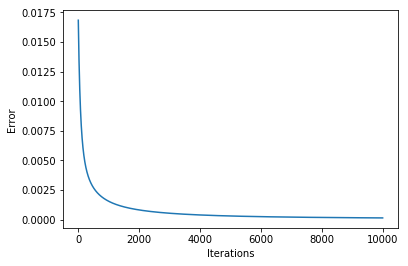

In [49]:
# Fit training set
test.fit(x, y, False)

In [50]:
# Load 2015 playoff data
playoff_data = pd.read_csv(os.path.join(curr_directory,'data_sets/2015_playoffs.csv'))

raw_playoff_results = np.array(list(playoff_data['PTS'] - playoff_data['PTS.1']))
raw_playoff_team_pairs = np.array(list(zip(playoff_data['Visitor/Neutral'], playoff_data['Home/Neutral'])))
raw_playoff_dates = np.array(list(playoff_data['Date']))

In [51]:
playoff_pairs = {}

for i in range(len(raw_playoff_team_pairs)): 
    team_1 = raw_playoff_team_pairs[i][0]
    team_2 = raw_playoff_team_pairs[i][1]
    if (team_1,team_2) in playoff_pairs.keys(): 
        # if results > 0 --> team A won --> +1
        # if results < 0 --> team B won --> -1
        if raw_playoff_results[i] > 0: 
            playoff_pairs[team_1,team_2] += 1
        else: 
            playoff_pairs[team_1,team_2] += -1
    elif (team_2,team_1) in playoff_pairs.keys():
        # if results > 0 --> team B won --> -1
        # if results < 0 --> team A won --> +1
        if raw_playoff_results[i] > 0: 
            playoff_pairs[team_2,team_1] += -1
        else: 
            playoff_pairs[team_2,team_1] += 1
    else: 
        if raw_playoff_results[i] > 0: 
            playoff_pairs[team_1,team_2] = 1
        else: 
            playoff_pairs[team_1,team_2] = -1
            
print(playoff_pairs)

{('WAS', 'TOR'): 4, ('NOP', 'GSW'): -4, ('MIL', 'CHI'): -2, ('DAL', 'HOU'): -3, ('BOS', 'CLE'): -4, ('BRK', 'ATL'): -2, ('POR', 'MEM'): -3, ('SAS', 'LAC'): -1, ('WAS', 'ATL'): -2, ('MEM', 'GSW'): -2, ('CHI', 'CLE'): -2, ('LAC', 'HOU'): -1, ('HOU', 'GSW'): -3, ('CLE', 'ATL'): 4, ('CLE', 'GSW'): -2}


In [52]:
playoff_teams = []
playoff_results = []
playoff_dates = []

for key in playoff_pairs: 
    playoff_teams.append([key[0], key[1]])
    playoff_results.append(playoff_pairs[key])
    playoff_dates.append('2015-04-10')
    
playoff_teams = np.array(playoff_teams)
playoff_results = np.array(playoff_results)
playoff_dates = np.array(playoff_dates)

    
playoff_x, playoff_y = test.process_data(playoff_teams, playoff_dates, playoff_results)

print(playoff_x)
print(playoff_y)

predicted_y = []
temp = playoff_x[0,:]
for i in range(playoff_x.shape[0]):
    x = playoff_x[i,:]
    print(np.mean(temp == x))
    
    x_new = np.reshape(x, (2*num_players + 1, 1))
    prediction = test.predict(x_new)
    if np.asscalar(prediction) > 0.5: 
        predicted_y.append(1)
    else: 
        predicted_y.append(0)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]
1.0
0.964193046185781
0.9652309289050337
0.9626362221069019
0.9610793980280228
0.9647119875454073
0.9636741048261547
0.9636741048261547
0.9839128178515828
0.9652309289050337
0.9652309289050337
0.9621172807472755
0.9647119875454073
0.964193046185781
0.9647119875454073


In [59]:
prediction_accuracy = np.mean(np.array(predicted_y) == np.array(playoff_y.T[0][:]))
print(prediction_accuracy)
print(predicted_y)
print(np.array(predicted_y) == np.array(playoff_y.T[0][:]))

0.7333333333333333
[1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0]
[ True  True  True  True  True  True False False  True  True  True False
  True False  True]


In [64]:
test_x, test_y = test.process_data(unique_teams[2230:3000], unique_dates[2230:3000], unique_game_results[2230:3000])

In [65]:
predicted_y = []
for i in range(test_x.shape[0]):
    x = test_x[i,:]
    
    x_new = np.reshape(x, (2*num_players + 1, 1))
    prediction = test.predict(x_new)
    if np.asscalar(prediction) > 0.5: 
        predicted_y.append(1)
    else: 
        predicted_y.append(0)
        
predicted_y = np.array(predicted_y)

In [66]:
print(np.mean(np.array(predicted_y) == np.array(test_y.T)))

0.6103896103896104
